In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %reload_ext autoreload

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import my_types
import rectification
import utils
import mops

# Input Files

In [5]:
DATA = Path("data")
OUTDIR = Path("output")

In [6]:
name  = "plush"
im1_name = DATA / (name + "1.jpg")
im2_name = DATA / (name + "2.jpg")

In [7]:
plane_name = DATA / (name + "_plane.pkl")

warp1_name = DATA / (im1_name.stem + "_w.jpg")
warp2_name = DATA / (im2_name.stem + "_w.jpg")

pts1_name = DATA / (im1_name.stem + "_w.pkl")
pts2_name = DATA / (im2_name.stem + "_w.pkl")

In [8]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

# Detect Correspondences

In [9]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)
im1.shape

(2268, 4032, 3)

In [10]:
im1_gray = utils.read_img(im1_name, gray=True)
im2_gray = utils.read_img(im2_name, gray=True)
im1_gray.shape

(2268, 4032)

In [11]:
_, im1_pts = harris.get_harris_corners(im1_gray)
_, im2_pts = harris.get_harris_corners(im2_gray)

In [12]:
len(im1_pts)

315

In [13]:
len(im2_pts)

563

In [14]:
im1_pts.dtype

dtype('int64')

In [15]:
h, w, c = im1.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print("input shape = ", im1.shape)
    print("target shape = ", h / r, w / r)
    
    print("resizing...")
    im1 = sk.transform.resize(im1, (im1.shape[0] // r, im1.shape[1] // r), anti_aliasing=True)
    im2 = sk.transform.resize(im2, (im2.shape[0] // r, im2.shape[1] // r), anti_aliasing=True)
    im1_pts //= r
    im2_pts //= r

im1.shape, im2.shape

RESIZE = True
ratio =  3
input shape =  (2268, 4032, 3)
target shape =  756.0 1344.0
resizing...


((756, 1344, 3), (756, 1344, 3))

# Image Rectification

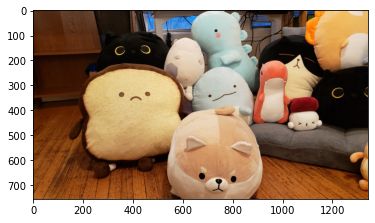

In [16]:
plt.imshow(im1)

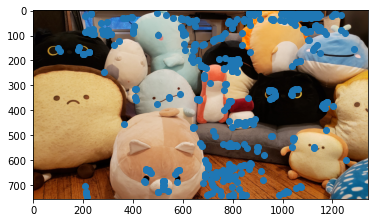

In [20]:
plt.imshow(im2)
plt.scatter(im2_pts[:, 0], im2_pts[:, 1])

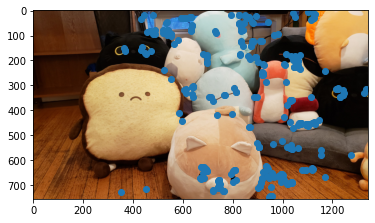

In [19]:
plt.imshow(im1)
plt.scatter(im1_pts[:, 0], im1_pts[:, 1])

# Match Features

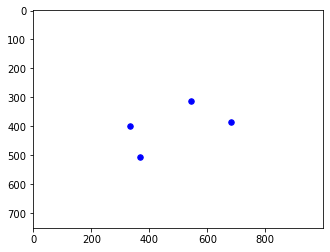

In [54]:
try:
    plane_pts = utils.load_points(plane_name)
except:
    %matplotlib tk
    plane_pts = utils.pick_points(im1, 4)
    %matplotlib inline
    # plane_pts = (im1_pts + im2_pts) / 2
    utils.save_points(plane_pts, plane_name)

if RESIZE:
    plane_pts /= r

canvas = np.ones_like(im1)
utils.plot_pts(canvas, plane_pts)

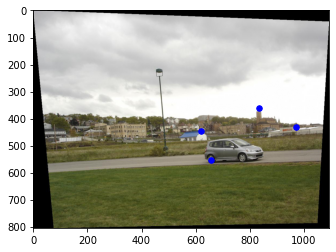

In [55]:
try:
    warp1 = utils.read_img(warp1_name)
    warp_pts1 = utils.load_points(pts1_name)

except:
    print("warping...")

    h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
    warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
    warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
    
    plt.imsave(warp1_name, warp1)
    utils.save_points(warp_pts1, pts1_name)

utils.plot_pts(warp1, warp_pts1)

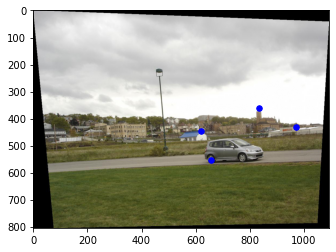

In [56]:
try:
    warp2 = utils.read_img(warp2_name)
    warp_pts2 = utils.load_points(pts2_name)

except:
    print("warping...")
    
    h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
    warp2, shift_pts2= homography.inverse_warp(im2, h_matrix2)
    warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

    plt.imsave(warp2_name, warp2)
    utils.save_points(warp_pts2, pts2_name)

utils.plot_pts(warp1, warp_pts1)

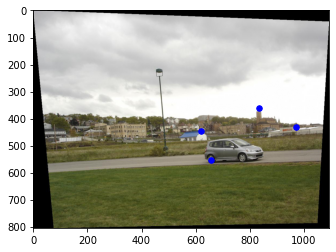

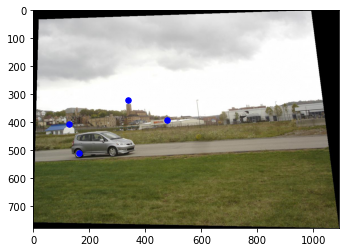

In [57]:
utils.plot_pts(warp1, warp_pts1)
utils.plot_pts(warp2, warp_pts2)

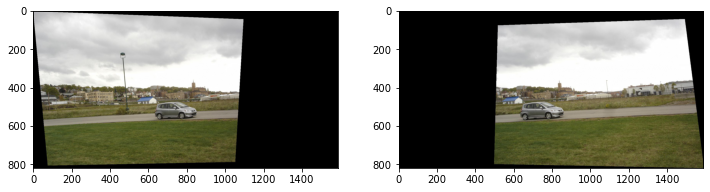

In [58]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
utils.show_two(aligned1, aligned2)

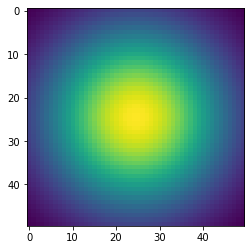

In [140]:
g = filters.gaussian_filter()
plt.imshow(g)

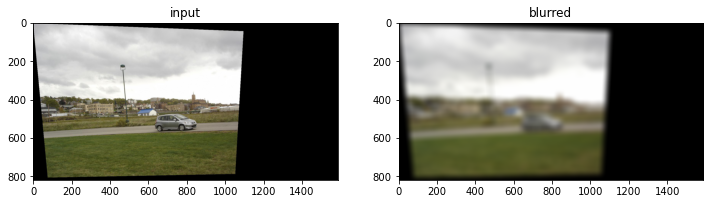

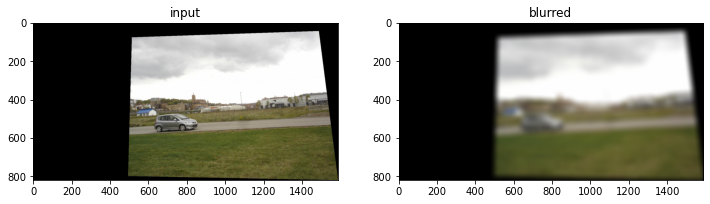

In [144]:
blended = rectification.two_band_blend(aligned1, aligned2)

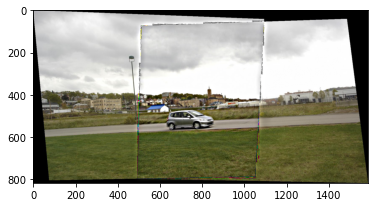

In [145]:
plt.imshow(blended)
plt.imsave(mosaic_name, blended)